In [1]:
import os

import numpy as np
import pandas as pd
import bloscpack as bp

import matplotlib.pyplot as plt

import imgaug as ia
import imgaug.augmenters as iaa

In [2]:
import fastai
from fastai.vision import *

from optim import Over9000

In [4]:
from torch.utils.data.dataloader import DataLoader
from data import Bengaliai_DS

In [5]:
from model import *
from model_utils import *

---

In [5]:
SEED = 20190819

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [6]:
pqs = [f for f in os.listdir('../input') if 'parquet' in f]
a = [pd.read_parquet(os.path.join('../input', f)) for f in pqs]
a = pd.concat(a, ignore_index=True)

In [8]:
a.info

<bound method DataFrame.info of             image_id    0    1    2    3    4    5    6    7    8  ...  32322  \
0             Test_0  247  253  253  252  252  252  252  253  253  ...    254   
1             Test_1  253  253  253  253  253  253  253  253  253  ...    255   
2             Test_2  253  253  253  253  253  252  251  252  252  ...    255   
3             Test_3  199  227  236  241  238  242  245  243  243  ...    222   
4             Test_4  243  246  251  252  251  249  250  250  251  ...    251   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
200847  Train_100415  255  255  255  255  255  255  254  254  254  ...    255   
200848  Train_100416  220  220  217  227  229  223  226  224  224  ...    255   
200849  Train_100417  249  248  244  244  244  245  248  251  253  ...    255   
200850  Train_100418  251  253  254  254  254  254  254  253  253  ...    254   
200851  Train_100419  249  254  255  255  255  255  254  254  255  ...    254

In [6]:
trn_imgs = bp.unpack_ndarray_from_file('../features/train_images.bloscpack')
# see preprocess notebook, it's shown that the train.csv data sequence is the same and can just load like this.
trn_lbls = pd.read_csv('../input/train.csv').iloc[:, 1:4].values

In [423]:
augs = iaa.SomeOf(
    (0, 3),
    [
        iaa.OneOf(
            [
                iaa.Affine(scale={"x": (0.8, 1.1), "y": (0.8, 1.1)}, rotate=(-15, 15), shear=(-15, 15)),
                iaa.PiecewiseAffine(scale=(0.02, 0.03)),
                iaa.PerspectiveTransform(scale=.09, keep_size=True),
            ]
        ),
        iaa.GaussianBlur(sigma=(0.5, 1.)),
#         iaa.OneOf(
#             [
#                 iaa.GaussianBlur(sigma=(0.5, 1.)),
#                 iaa.MotionBlur(k=(7, 13), angle=[-45, 45]),
#                 iaa.MedianBlur(k=(3, 5)),
#             ]
#         ),
        iaa.OneOf(
            [
                iaa.DirectedEdgeDetect(alpha=(.6, .8), direction=(0.0, 1.0)),
                iaa.Emboss(alpha=(.5, 1.), strength=(.1, 4)),
            ]
        ),
#         iaa.CoarseDropout((0.05, 0.15), size_percent=(0.15, 0.35)),
#         iaa.Fog(),
    ],
    random_order=True
)

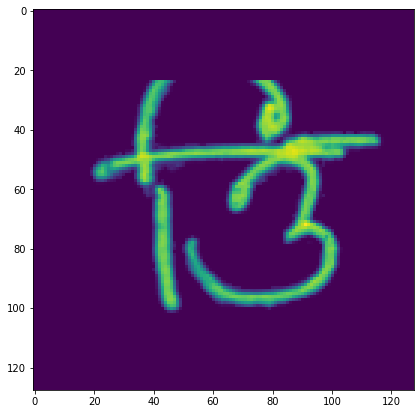

In [18]:
augs = iaa.ElasticTransformation(alpha=0)
img_arr = training_set[100][0][0][0]
# img_arr = np.stack([img_arr, img_arr, img_arr], -1)
# img_arr = img_arr[np.newaxis, :]
plt.figure(figsize=(7, 7))
plt.imshow(augs(image=img_arr))

In [7]:
training_set = Bengaliai_DS(trn_imgs[:160000, np.newaxis], trn_lbls[:160000], transform=None, norm=False)
# validation_set = DS_TRN(trn_imgs[160000:, np.newaxis], trn_lbls[160000:])

# training_loader = DataLoader(training_set, batch_size=64, shuffle=True, num_workers=4)
# validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=4)

# dat_bunch = DataBunch(train_dl=training_loader, valid_dl=validation_loader)

---
### model

In [9]:
device = 'cuda:0'
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

In [10]:
predictor = PretrainedCNN(out_dim=n_total)
classifier = BengaliClassifier(predictor)#.to(device)

In [11]:
learn = Learner(
    dat_bunch,
    classifier,
    loss_func=Loss_combine(),
    opt_func=Over9000,
    metrics=[Metric_grapheme(), Metric_vowel(), Metric_consonant(),Metric_tot()]
)

logger = CSVLogger(learn, 'Seresnext_DensenetStarterSetup_Myaugs')

learn.clip_grad = 1.0
learn.split([classifier.predictor.lin_layers])
# learn.split([classifier.head1])
learn.unfreeze()

In [12]:
learn.fit_one_cycle(
    32,
    max_lr=slice(0.2e-2,1e-2),
    wd=[1e-3, 0.1e-1],
    pct_start=0.0,
    div_factor=100,
    callbacks=[logger, SaveModelCallback(learn,monitor='metric_tot', mode='max', name='Seresnext_DensenetStarterSetup_Myaugs'), MixUpCallback(learn)]
)

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.429123,0.411018,0.849430,0.943026,0.894503,0.884097,39:29


KeyboardInterrupt: 